In [36]:
import pandas as pd
import math
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy import diff
from scipy.signal import butter, lfilter



In [37]:
d= pd.read_csv('lab4data/circleimu.csv')
ds=pd.read_csv('lab4data/circlegps.csv')
dp=pd.read_csv('lab4data/pathimu.csv')
dps=pd.read_csv('lab4data/pathgps.csv')
mag_x=d['field.MagField.magnetic_field.x']
mag_y=d['field.MagField.magnetic_field.y']
timeimu=np.array(d['field.Header.stamp'])
timeimu=(timeimu-1.69826424943413e+18)/1000000000
timeimu[3000]

74.998220032

In [38]:

mag_x=np.array(d['field.MagField.magnetic_field.x'])
mag_y=np.array(d['field.MagField.magnetic_field.y'])
mag_z=d['field.MagField.magnetic_field.z']
mag_x

array([-0.0886, -0.0879, -0.0893, ..., -0.0306, -0.0303, -0.0303])

array([-0.0886, -0.0879, -0.0893, ..., -0.0306, -0.0303, -0.0303])

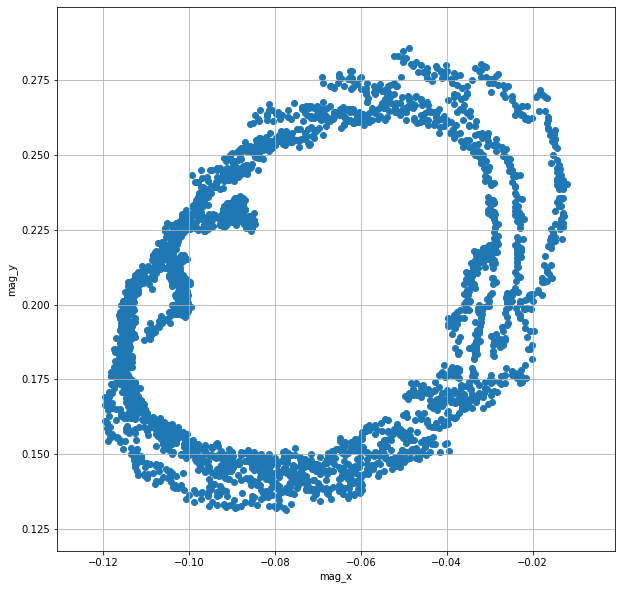

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(mag_x),np.array(mag_y))
plt.grid(True)
plt.xlabel("mag_x")
plt.ylabel("mag_y")
mag_x

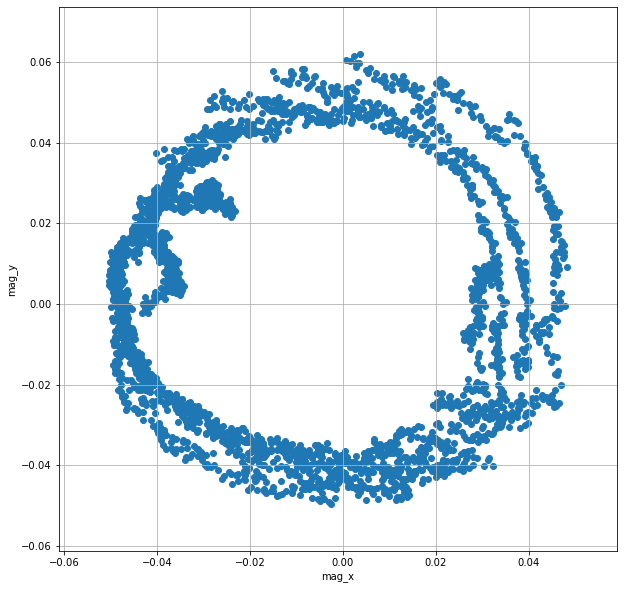

In [40]:
mc=[]
cc=[[0.99 ,-0.1443,0],[-0.1443, 0.75, 0],[0, 0, 1]]
cx=[[mag_x+0.065],[mag_y-0.2],[mag_z-0]]
cx=np.array(cx)
np.shape(cx)
# for data in cx:
#     print (data[data])
for i in range(3878):
    mc.append(np.dot(cc,(cx[:,:,i])))
mc=np.array(mc)
for i in range(3878):
    mx=mc[:,0,0]
    my=mc[:,1,0]
    mz=mc[:,2,0]
plt.figure(figsize=(10,10))
plt.grid(True)
# plt.ylim(ymin=-0.07)
# plt.xlim(xmin=-0.07)
plt.xlabel("mag_x")
plt.ylabel("mag_y")
plt.scatter(mx,my)


array([ -2.35033454,  -2.39581318,  -2.36929281, ..., -25.36257892,
       -25.3336247 , -25.37550475])

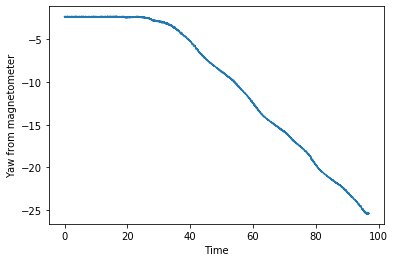

In [41]:
#Yaw from Magnetometer, to low pass 
yaw_mag=np.arctan2(-my,mx) #radian
yaw_mag=np.unwrap(yaw_mag)
plt.plot(timeimu,yaw_mag)
plt.xlabel("Time")
plt.ylabel("Yaw from magnetometer")
yaw_mag

array([ 1.67000000e-04,  2.26843069e-04, -6.70786048e-04, ...,
       -2.28424383e+01, -2.28387621e+01, -2.28424922e+01])

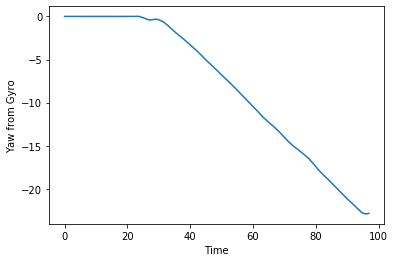

In [42]:
#Yaw from gyro
yaw_rate=np.array(d['field.IMU.angular_velocity.z'])
yaw_gyro=cumtrapz(yaw_rate,timeimu)+yaw_rate[1:]
yaw_gyro=np.insert(yaw_gyro,0,0+yaw_rate[0])
plt.plot(timeimu,yaw_gyro)
plt.xlabel("Time")
plt.ylabel("Yaw from Gyro")

yaw_gyro

0.00019117172814366132

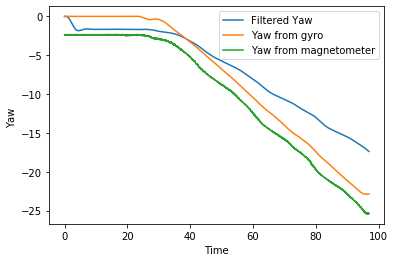

In [48]:
#Filter
# Define filter parameters
cut_off_freq=0.01 # Cutoff frequency for low-pass filter
filter_order = 4  # Filter order
# Initialize low-pass (for magnetometer) and high-pass (for gyro) filters
gyro_b, gyro_a = butter(filter_order, 0.01, btype='high')
mag_b, mag_a = butter(filter_order, 0.01, btype='low')
# yaw_gyro=np.unwrap(yaw_gyro)
# yaw_mag=np.unwrap(yaw_mag)
filtered_gyro = np.zeros(len(yaw_gyro))
filtered_mag = np.zeros(len(yaw_mag))
yaw_estimate = np.zeros(len(yaw_gyro))
# Apply filters to gyro and magnetometer data
filtered_gyro = lfilter(gyro_b, gyro_a, yaw_gyro)
filtered_mag = lfilter(mag_b, mag_a, yaw_mag)

# Complementary filter
alpha = 0.7  # Weight for magnetometer data (low-pass filter)
gyro_weight = 1.0 - alpha  # Weight for gyro data (high-pass filter)

for i in range(len(yaw_gyro)):
    
    # Apply filters
    filtered_gyro_yaw = filtered_gyro[i]
    filtered_mag_yaw = filtered_mag[i]
    
    # Combine data using complementary filter
    yaw_estimate[i] = alpha * filtered_mag_yaw + gyro_weight*filtered_gyro_yaw
    # Ensure the yaw estimate stays within the range of -π to π
    #yaw_estimate = (yaw_estimate + np.pi) % (2 * np.pi) - np.pi
plt.plot(timeimu,yaw_estimate)
plt.xlabel("Time")
plt.ylabel("Yaw ")
plt.plot(timeimu,yaw_gyro)
plt.plot(timeimu,yaw_mag)
plt.legend(['Filtered Yaw','Yaw from gyro','Yaw from magnetometer'])
max(yaw_estimate)

[0.00000000e+00 7.47002880e-04 1.41294746e-03 ... 5.17241645e+00
 5.18960328e+00 5.20508464e+00]


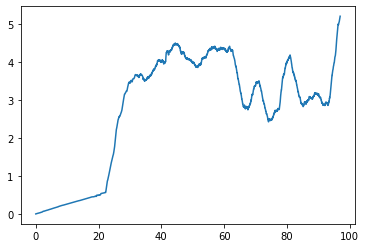

In [44]:
 #velocity from linear acceleration
lin_acc_x=np.array(d['field.IMU.linear_acceleration.x']+0.651) 
lin_acc_y=np.array(d['field.IMU.linear_acceleration.y']) 
lin_acc_z=np.array(d['field.IMU.linear_acceleration.z']) 
v_x=cumtrapz(lin_acc_x,timeimu)
v_x=np.insert(v_x,0,0)
print(v_x)
v_y=cumtrapz(lin_acc_y,timeimu)
v_y=np.insert(v_y,0,0)
v=(v_y**2+v_x**2)**0.5
# v_z=integrate.cumtrapz(lin_acc_z,timeimu)

#plt.plot(timeimu,lin_acc_x)
plt.plot(timeimu,v_x)

4.434190219963634

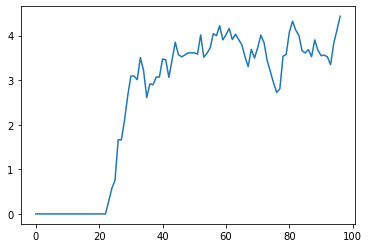

In [45]:
#velocity from GPS
timegps=np.array((ds['field.header.stamp']-1698264250218439340)/1000000000)
easting=np.array(ds['field.utm_easting'])
northing=np.array(ds['field.utm_northing'])
velocity_x=diff(easting)/diff(timegps)
velocity_x = np.insert(velocity_x, 0, 0)
velocity_y=diff(northing)/diff(timegps)
diff
velocity_y= np.insert(velocity_y, 0, 0)
velocity=(velocity_y**2+velocity_x**2)**0.5
plt.plot(timegps,velocity)
max(velocity)
